In [535]:
#code refercing from https://github.com/jasoncoding13/nmf
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
import random
from Initialize import random_init
from Initialize import kmeans_init
from Initialize import pca_kmeans_init
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import StratifiedKFold
MAX_STEPS = 200
SKIP_STEPS = 10
TOL = 1e-4

In [458]:
def load_data(data,path,reduce=None):
    
    
    
    if data == 'ORL':
        path = './data/ORL'
    elif data == 'EYB':
        path = './data/CroppedYaleB'
    
    
    
    image_shape, reduce = compute_image_shape(data, reduce)
    images, labels = [], []
    if data == 'ORL' or data == 'EYB':
        for i, person in enumerate(sorted(os.listdir(path))):
            if not os.path.isdir(os.path.join(path, person)):
                continue
            for fname in os.listdir(os.path.join(path, person)):
                
                if fname.endswith('Ambient.pgm'):
                    continue
                if not fname.endswith('.pgm'):
                    continue
                
                img = Image.open(os.path.join(path, person, fname))
                img = img.convert('L')  
                
                img = img.resize(np.flip(image_shape))
                
                img = np.asarray(img).reshape((-1, 1))
                
                images.append(img)
                labels.append(i)
   
    
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    
    return images, labels

In [459]:
data = 'EYB'
X, y = load_data(data,'s')

In [460]:
len(X)

2016

In [461]:
len(y)

2414

In [462]:
def compute_image_shape(data, reduce=None):
    
    if data == 'ORL':
        if not reduce:
            reduce = 3
        image_shape = [i // reduce for i in (112, 92)]
    elif data == 'EYB':
        if not reduce:
            reduce = 4
        image_shape = [i // reduce for i in (192, 168)]
    
    return np.array(image_shape), reduce

In [463]:
image_shape, reduce = compute_image_shape(data)

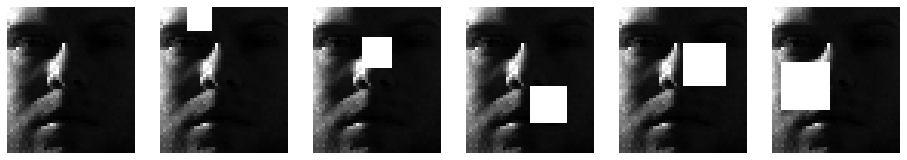

In [464]:
plt.figure(figsize=(16, 9))
plt.subplot(161)
plt.imshow(X[:, 0].reshape(image_shape), cmap=plt.cm.gray)
plt.axis('off')
for i in range(5):
    plt.subplot(1, 6, i+2)
    X_noised_0 = add_block_noise(X[:, 0:1], i * 2+ 8, data, reduce)
    plt.imshow(X_noised_0[:, 0].reshape(image_shape), cmap=plt.cm.gray)
    plt.axis('off')

In [465]:
def add_block_noise(X, b, data, reduce=None):
    
    n_feature, n_sample = X.shape
    image_shape, reduce = compute_image_shape(data, reduce)
    X = X.copy().reshape((*image_shape, n_sample))
    
    max_block_index_h, max_block_index_w = image_shape - b + 1
    
    for i in range(n_sample):
        block_index_h = np.random.randint(max_block_index_h)
        block_index_w = np.random.randint(max_block_index_w)
        X[block_index_h:block_index_h+b,
          block_index_w:block_index_w+b,
          i] = 255
    X = X.reshape((n_feature, n_sample))
    return X

In [466]:
#EYB block
X_noised = add_block_noise(X, b=13, data=data)

In [467]:
def print_log(string):
    
    sys.stdout.write(string+'\n')
    sys.stdout.flush()

In [468]:
class BaseNMF():
    
    def __init__(
            self,
            n_components,
            init,
            tol,
            max_iter,
            skip_iter):
        self.n_components = n_components
        self.init = init
        self.tol = tol
        self.max_iter = max_iter
        self.skip_iter = skip_iter

    def _compute_loss(self, X, D, R):
        return None

    def _update(self, X, D, R):
        return None

    def _init(self, X):
        if self.init == 'random':
            D, R = random_init(self.n_components, X)
        
        elif self.init == 'kmeans':
            D, R = kmeans_init(self.n_components, X)
        elif self.init == 'pcakmeans':
            D, R = pca_kmeans_init(self.n_components, X)
        return D, R

    def fit(self, X):
        
        D, R = self._init(X)
        losses = [self._compute_loss(X, D, R)]
        for iter_ in range(self.max_iter):
            D, R = self._update(X, D, R)
            # check converagence
            if iter_ % self.skip_iter == 0:
                losses.append(self._compute_loss(X, D, R))
                criterion = abs(losses[-1] - losses[-2]) / losses[-2]
                print_log('iter-{:>4}, criterion-{:0<10.5}, {:>13}'.format(
                        iter_, criterion, losses[-1]))
                if criterion < TOL:
                    break
        return D, R

In [469]:
class WeightedNMF(BaseNMF):
    def __init__(
            self,
            n_components,
            init='random',
            tol=1e-4,
            max_iter=200,
            skip_iter=10):
        super().__init__(n_components, init, tol, max_iter, skip_iter)

    def _compute_loss(self, X, D, R):
        return None

    def _update_weight(self, X, D, R):
        return None

    def _update(self, X, D, R):
        # update W
        W = self._update_weight(X, D, R)
        # update D
        denominator_D = (W * D.dot(R)).dot(R.T)
        denominator_D[denominator_D == 0] = np.finfo(np.float32).eps
        D = D * ((W * X).dot(R.T)) / denominator_D
        # update R
        denominator_R = D.T.dot(W * D.dot(R))
        denominator_R[denominator_R == 0] = np.finfo(np.float32).eps
        R = R * (D.T.dot(W * X)) / denominator_R
        return D, R

In [470]:
class NMF(WeightedNMF):
    
    def _compute_loss(self, X, D, R):
        return np.linalg.norm(X - D.dot(R)) ** 2

    def _update_weight(self, X, D, R):
        return 1

In [471]:
class CIM_NMF(WeightedNMF):
    
    def _compute_loss(self, X, D, R):
        twice_sigma_square = np.mean(np.square(X - D.dot(R)))
        return np.sum(1 - 1 / np.sqrt(np.pi * twice_sigma_square) *
                      (np.exp(-np.square(X - D.dot(R)) / twice_sigma_square)))

    def _update_weight(self, X, D, R):
        E_square = np.square(X - D.dot(R))
        twice_sigma_square = np.mean(E_square)
        return np.exp(- E_square / twice_sigma_square)

In [472]:
def compute_RRE(X, X_hat):
    
    return np.linalg.norm(X - X_hat) / np.linalg.norm(X)


In [473]:
def compute_ACC_NMI(R, Y):
    
    kmeans = KMeans(n_clusters=len(set(Y))).fit(R.T)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = (kmeans.labels_ == i)
        
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]
    acc = accuracy_score(Y, Y_pred)
    nmi = normalized_mutual_info_score(Y, Y_pred, average_method='arithmetic')
    return acc, nmi

In [474]:
def compute_metrics(X, X_hat, R, Y):
    
    acc, nmi = compute_ACC_NMI(R, Y)
    RRE=compute_RRE(X, X_hat)
    metrics = {'RRE': compute_RRE(X, X_hat),
               'ACC': acc,
               'NMI': nmi}
    print_log('RRE: {RRE}, ACC: {ACC}, NMI:{NMI}'.format(**metrics))
    return RRE,acc,nmi

In [475]:
def reconstruct(X, X_noised, X_hat, data, reduce=None, ind=None, path=None):
    
    image_shape, reduce = compute_image_shape(data, reduce)
    if not ind:
        if data in ('ORL', 'EYB'):
            ind = np.random.randint(X.shape[1])
        elif data == 'AR':
            ind = np.random.randint(7, 13) + np.random.randint(200) * 13
    plt.figure(figsize=(16, 9))
    plt.subplot(131)
    plt.imshow(X[:, ind].reshape(image_shape), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Image(Original)')
    plt.subplot(132)
    plt.imshow(X_noised[:, ind].reshape(image_shape), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Image(Noised)')
    plt.subplot(133)
    plt.imshow(X_hat[:, ind].reshape(image_shape), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Image(Reconstructed)')
    if path:
        plt.savefig(path)
        print_log(f'Save image at {path}')
    plt.show()

In [476]:
def inspect_dictionary(D, data, reduce=None, n_cols=5):
    
    image_shape, reduce = compute_image_shape(data, reduce)
    nrows = D.shape[1] // n_cols
    nrows += 1 if D.shape[1] % n_cols else 0
    for i in range(nrows):
        plt.figure(figsize=(16, 9))
        for j in range(n_cols):
            plt.subplot(1, n_cols, j+1)
            plt.imshow(D[:, i*n_cols+j].reshape(image_shape), cmap=plt.cm.gray)
            plt.axis('off')
        plt.show()

In [477]:
cimnmf = CIM_NMF(n_components=40, tol=1e-7, max_iter=10000, skip_iter=1000)

In [478]:
D, R = cimnmf.fit(X_noised)

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591


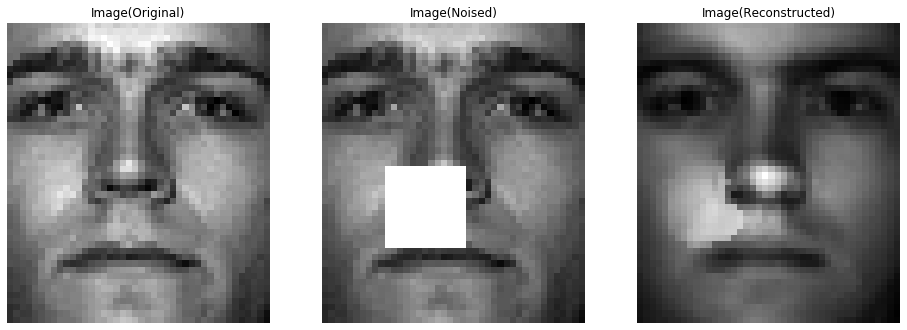

In [479]:
#compute_metrics(X, D.dot(R), R, y)
reconstruct(X, X_noised, D.dot(R), data=data)

In [480]:
data2='ORL'

In [481]:
X2, y2 = load_data(data2,'s')

In [482]:
image_shape2, reduce = compute_image_shape(data2)

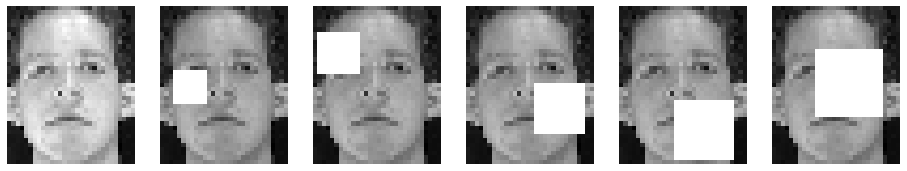

In [483]:
plt.figure(figsize=(16, 9))
plt.subplot(161)
plt.imshow(X2[:, 0].reshape(image_shape2), cmap=plt.cm.gray)
plt.axis('off')
for i in range(5):
    plt.subplot(1, 6, i+2)
    X_noised_0 = add_block_noise(X2[:, 0:1], i * 2+ 8, data2, reduce)
    plt.imshow(X_noised_0[:, 0].reshape(image_shape2), cmap=plt.cm.gray)
    plt.axis('off')

In [484]:
#ORL block
X_noised2 = add_block_noise(X2, b=13, data=data2)

In [485]:
cimnmf = CIM_NMF(n_components=40, tol=1e-7, max_iter=5000, skip_iter=1000)

In [486]:
D, R = cimnmf.fit(X_noised2)

iter-   0, criterion-0.00153040, 441554.8452618588
iter-1000, criterion-0.00494700, 439370.4642366288
iter-2000, criterion-0.00015815, 439300.97619425575
iter-3000, criterion-8.3225e-05, 439264.41540931014


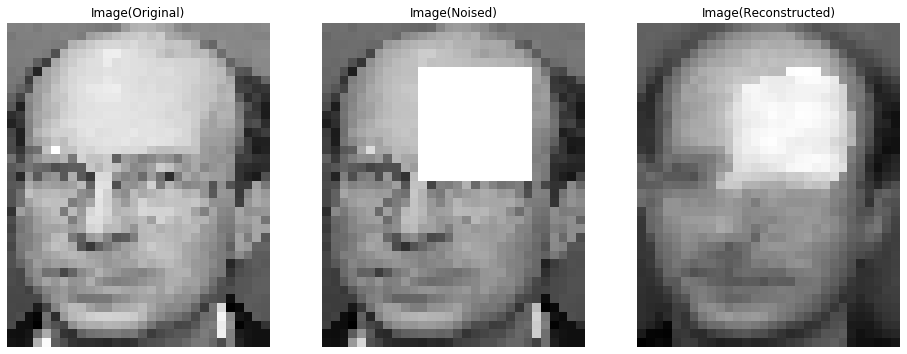

In [487]:
#compute_metrics(X2, D.dot(R), R, y2)
reconstruct(X2, X_noised2, D.dot(R), data=data2)

In [488]:
def add_salt_noise(X, p, data, reduce=None):
    
    n_feature, n_sample = X.shape
    X = X.copy()
    noised_size = int(n_feature * p)
    for i in range(n_sample):
        index = np.arange(n_feature)
        np.random.shuffle(index)
        X[index[:noised_size//2+1], i] = 0
        X[index[noised_size//2+1:noised_size], i] = 255
    return X


iter-   0, criterion-0.00087615, 4840882.707973414
iter-1000, criterion-0.00397970, 4821617.6822141055
iter-2000, criterion-3.3159e-05, 4821457.8038384905


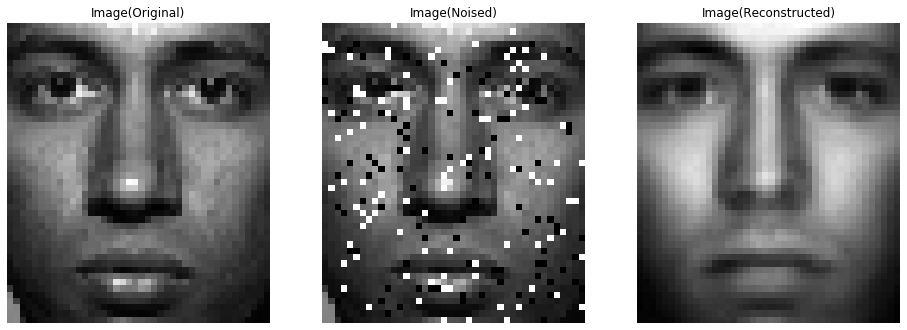

In [490]:
#EYB SALT
X_noised3 = add_salt_noise(X, p=0.1, data=data)
cimnmf = CIM_NMF(n_components=40, tol=1e-7, max_iter=10000, skip_iter=1000)
D, R = cimnmf.fit(X_noised3)
#compute_metrics(X, D.dot(R), R, y)
reconstruct(X, X_noised3, D.dot(R), data=data)

RRE: 0.21894351218469219, ACC: 0.23902236951118475, NMI:0.2881682494807416


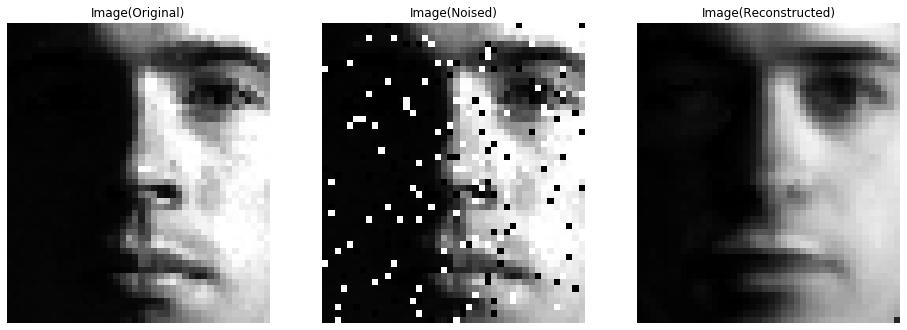

In [271]:
#compute_metrics(X, D.dot(R), R, y)
reconstruct(X, X_noised3, D.dot(R), data=data)

In [352]:
def plot_result(models, data, noise, metric, path=None):
    
    fig, ax = plt.subplots(figsize=(16, 9))
    module_path = os.path.dirname(__file__)
    for name in os.listdir(f'{module_path}/results'):
        lst_name = name.split('.')[0].split('_')
        model = '_'.join(lst_name[0:-2])
        if data in name and noise in name and model in models:
            df_cv = pd.read_csv(f'{module_path}/results/{name}')
            ax.plot(df_cv[f'mean_{metric}'], label=model)
    xticklabels = df_cv['noise_param']
    ax.grid(True)
    ax.legend()
    ax.set_title(f'{metric} VS {noise} parameter of different NMFs')
    ax.set_xlabel(f'{noise} parameter')
    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(metric)
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    plt.show()

In [491]:
#base nmf
def base_nmf(X, n_components, init=random_init, steps=MAX_STEPS, **kwargs):
    def compute_loss(X, D, R):
        return np.linalg.norm(X - D.dot(R))
    D, R = init(n_components, X)
    if init == kmeans_init:
        R += ADD_R
    losses = [compute_loss(X, D, R)]
    for step in range(steps):
        denominator_D = D.dot(R).dot(R.T)
        denominator_D[denominator_D == 0] = np.finfo(np.float32).eps
        D = D * (X.dot(R.T)) / denominator_D
        denominator_R = (D.T.dot(D).dot(R))
        denominator_R[denominator_R == 0] = np.finfo(np.float32).eps
        R = R * (D.T.dot(X)) / denominator_R
        # evaluate and check converagence
        losses.append(compute_loss(X, D, R))
        criterion = abs(losses[-1] - losses[-2]) / losses[-2]
        if step % SKIP_STEPS == 0:
            print(f'loss step-{step}: {losses[-1]}')
            print(f'criterion: {criterion}')
            if criterion < TOL:
                break
    return D, R, losses

loss step-0: 156373.10445316735
criterion: 0.17167677727776212
loss step-10: 141407.18358338758
criterion: 0.028950699309266872
loss step-20: 113857.03864245543
criterion: 0.02613914721499976
loss step-30: 93221.99839095709
criterion: 0.014057450711406143
loss step-40: 84526.90010934959
criterion: 0.007078805870728871
loss step-50: 80213.17266610147
criterion: 0.004056610552558285
loss step-60: 77707.00047539876
criterion: 0.002587593023398595
loss step-70: 76092.41260578013
criterion: 0.001755240212324121
loss step-80: 74991.0278324071
criterion: 0.0012472091937333941
loss step-90: 74202.80980647467
criterion: 0.0009220702401515835
loss step-100: 73611.09011478015
criterion: 0.0007138178227085596
loss step-110: 73146.95509210817
criterion: 0.0005735075493685436
loss step-120: 72769.75894553716
criterion: 0.000475584385304177
loss step-130: 72453.76193016271
criterion: 0.00040463810663137454
loss step-140: 72184.43981599972
criterion: 0.000347983456819663
loss step-150: 71952.209589092

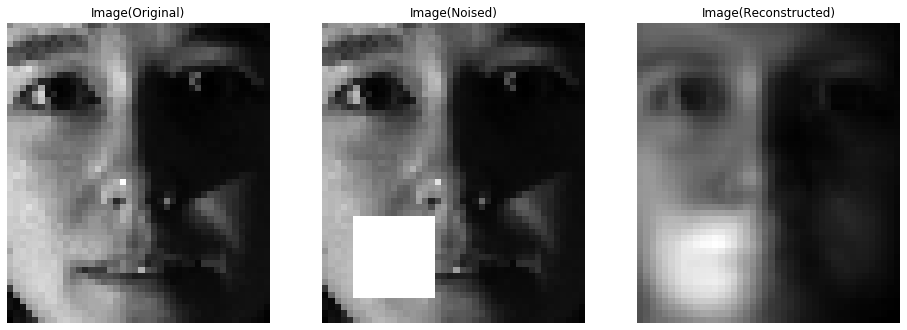

In [492]:
D, R, losses = base_nmf(X_noised, n_components = 40, init=random_init, steps=MAX_STEPS)
#compute_metrics(X, D.dot(R), R, y)
reconstruct(X, X_noised, D.dot(R), data=data)

loss step-0: 145551.5433307791
criterion: 0.16894794674198693
loss step-10: 131276.71517347265
criterion: 0.025921869401362284
loss step-20: 121632.82989557895
criterion: 0.003018349784162726
loss step-30: 118289.4558650116
criterion: 0.0022911111635687048
loss step-40: 116505.82964914001
criterion: 0.001146009890973906
loss step-50: 115345.69437408724
criterion: 0.0009072361175045753
loss step-60: 114419.84309439233
criterion: 0.0007260350892999242
loss step-70: 113688.07006739912
criterion: 0.0005775265238176834
loss step-80: 113108.01813563364
criterion: 0.000461722253656077
loss step-90: 112644.16485876114
criterion: 0.00037285203676150645
loss step-100: 112268.51137242105
criterion: 0.0003048526823492113
loss step-110: 111960.41374938055
criterion: 0.00025209984962760713
loss step-120: 111704.98641994546
criterion: 0.00021032667482919488
loss step-130: 111491.70355456078
criterion: 0.00017640958019035348
loss step-140: 111312.58787734341
criterion: 0.00014881243497303482
loss step

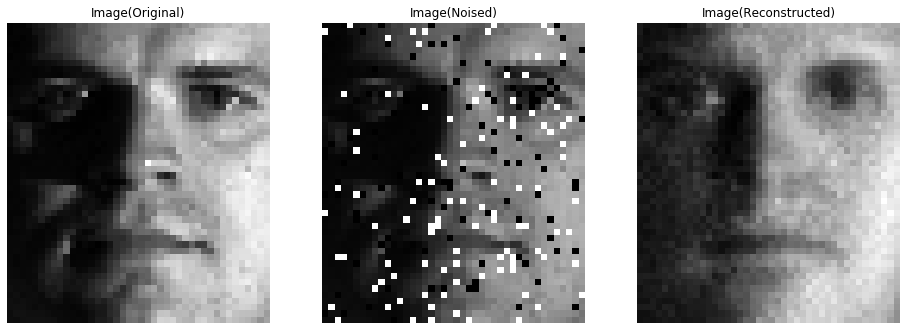

In [357]:
D, R, losses = base_nmf(X_noised3, n_components = 40, init=random_init, steps=MAX_STEPS)
#compute_metrics(X, D.dot(R), R, y)
reconstruct(X, X_noised3, D.dot(R), data=data)

loss step-0: 38118.26684445636
criterion: 0.333157701295938
loss step-10: 36840.037078967
criterion: 0.005259728105442868
loss step-20: 32266.228887866662
criterion: 0.019157500080561475
loss step-30: 27437.56075574665
criterion: 0.012082849833766628
loss step-40: 25031.631205676887
criterion: 0.007434744794387833
loss step-50: 23522.407165512817
criterion: 0.005369499041825325
loss step-60: 22455.044675700923
criterion: 0.004113512666156489
loss step-70: 21653.13117520569
criterion: 0.003279331742915972
loss step-80: 21026.552530989557
criterion: 0.0026736209885568907
loss step-90: 20526.027092305663
criterion: 0.0022032810684418733
loss step-100: 20121.825580367593
criterion: 0.0018215041323377584
loss step-110: 19793.07156747841
criterion: 0.0015124054484771303
loss step-120: 19523.28560226552
criterion: 0.0012643957733194698
loss step-130: 19299.614242823667
criterion: 0.0010660258963694953
loss step-140: 19112.067081136178
criterion: 0.0009077732394927155
loss step-150: 18952.9413

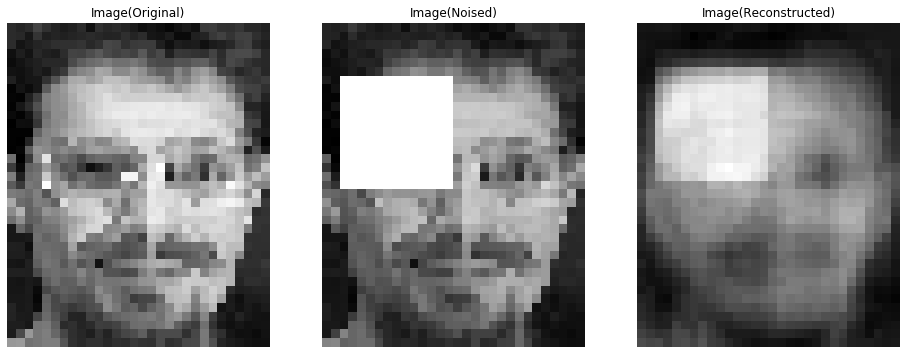

In [493]:
D, R, losses = base_nmf(X_noised2, n_components = 40, init=random_init, steps=MAX_STEPS)
#compute_metrics(X2, D.dot(R), R, y2)
reconstruct(X2, X_noised2, D.dot(R), data=data2)

loss step-0: 36848.43952926953
criterion: 0.27134381313888584
loss step-10: 36077.71861051168
criterion: 0.0019468261473829438
loss step-20: 35152.188208254665
criterion: 0.0033040097580598064
loss step-30: 33954.29094906282
criterion: 0.003203721052905073
loss step-40: 33022.86664570011
criterion: 0.002469655083519828
loss step-50: 32333.812756277417
criterion: 0.0018172285528213028
loss step-60: 31844.179114510505
criterion: 0.0013170532119750422
loss step-70: 31485.71156526814
criterion: 0.0010016130174619435
loss step-80: 31209.09623710315
criterion: 0.0007958732391532944
loss step-90: 30987.666959760925
criterion: 0.0006497030518060383
loss step-100: 30806.27420375218
criterion: 0.0005398978969687882
loss step-110: 30655.373167983973
criterion: 0.0004536652630528841
loss step-120: 30528.7207976102
criterion: 0.0003835158733907694
loss step-130: 30421.710315122302
criterion: 0.0003262839532995525
loss step-140: 30330.664667603578
criterion: 0.0002792406669801707
loss step-150: 3025

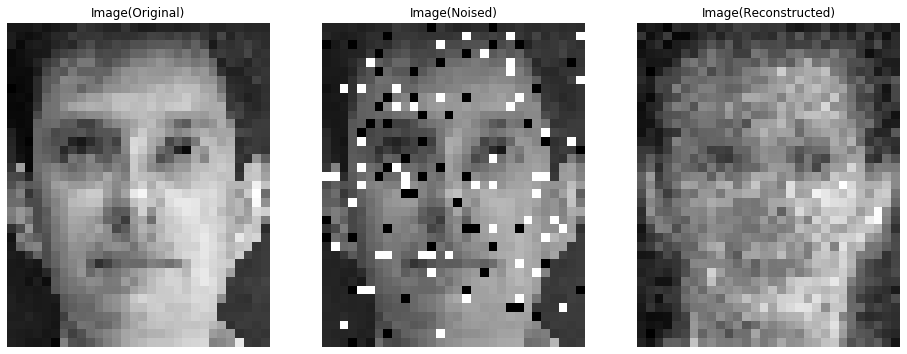

In [494]:
X_noised4 = add_salt_noise(X2, 0.1, data2, reduce)
D, R, losses = base_nmf(X_noised4, n_components = 40, init=random_init, steps=MAX_STEPS)
#compute_metrics(X2, D.dot(R), R, y2)
reconstruct(X2, X_noised4, D.dot(R), data=data2)

In [373]:
def data_split(data, split):
    n = data.shape[1]
    k = int(n*split)
    
    temp = np.random.permutation(data)[:,:k]

    return temp

In [496]:
def data_sampling(data,p,n,split,reduce,dataname = "EYB"):
    RRE_avg=[]
    ACC_avg=[]
    NMI_avg=[]
    for i in range(n):
        data_splited=data_split(data,split=split)
        noise_data = add_salt_noise(data_splited, p, data = dataname, reduce=4)
        D, R, losses = base_nmf(noise_data, n_components = 40, init=random_init, steps=MAX_STEPS)
        rre,acc,nmi=compute_metrics(data_splited, D.dot(R), R, y)
        reconstruct(data, noise_data, D.dot(R), data=dataname)
        RRE_avg.append(rre)
        ACC_avg.append(acc)
        NMI_avg.append(nmi)
    rre_avg=np.mean(RRE_avg)
    acc_avg=np.mean(ACC_avg)
    nmi_avg=np.mean(NMI_avg)
    print("average RRE:{},average acc:{},average nmi:{}".format(rre_avg,acc_avg,nmi_avg))

loss step-0: 145561.85090620987
criterion: 0.16899268967770964
loss step-10: 130039.43712553252
criterion: 0.024036563824032856
loss step-20: 121594.65385178223
criterion: 0.00318990500655381
loss step-30: 118258.2891191073
criterion: 0.0021880346223605946
loss step-40: 116505.81729331019
criterion: 0.0011582166855023158
loss step-50: 115319.31581028712
criterion: 0.0009308330644123857
loss step-60: 114378.14924474881
criterion: 0.0007315763527556401
loss step-70: 113645.30583037774
criterion: 0.0005771110704401354
loss step-80: 113065.83040841487
criterion: 0.00046141063789684753
loss step-90: 112604.01593704877
criterion: 0.0003695339390177047
loss step-100: 112235.08137443614
criterion: 0.0002969854226902212
loss step-110: 111937.90714799655
criterion: 0.00024125852727852927
loss step-120: 111695.4384096809
criterion: 0.00019846763997574844
loss step-130: 111495.18953270074
criterion: 0.00016503398038961208
loss step-140: 111328.12281452025
criterion: 0.00013850054615425434
loss ste

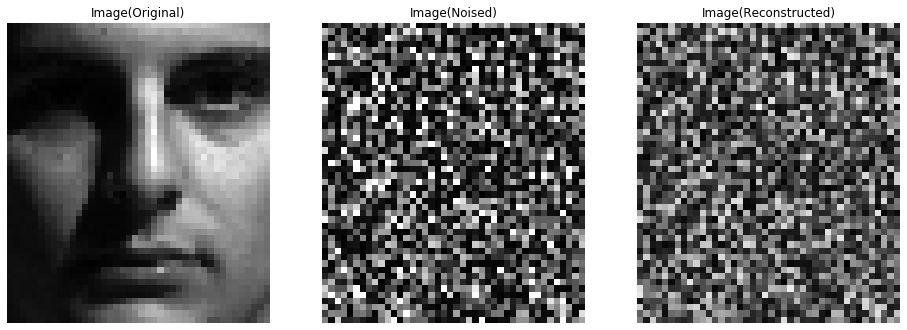

loss step-0: 145539.9318232975
criterion: 0.16892868683425513
loss step-10: 131175.36002351937
criterion: 0.025637042561861535
loss step-20: 121831.78338658443
criterion: 0.0029820160382617207
loss step-30: 118531.15670037853
criterion: 0.002312781047223895
loss step-40: 116725.69838499966
criterion: 0.0011158391645070315
loss step-50: 115609.39251851615
criterion: 0.0008757954447304005
loss step-60: 114695.79097846308
criterion: 0.0007293017690657346
loss step-70: 113936.67368625713
criterion: 0.0006142586513351475
loss step-80: 113301.40940284352
criterion: 0.00051482135293975
loss step-90: 112777.71254493078
criterion: 0.00042225928510774196
loss step-100: 112353.4334695409
criterion: 0.00034192983740543686
loss step-110: 112011.21796300057
criterion: 0.00027712473373256034
loss step-120: 111733.26808855079
criterion: 0.00022692586226347376
loss step-130: 111504.68191484835
criterion: 0.00018807262639902766
loss step-140: 111314.61827524868
criterion: 0.00015731065833098388
loss ste

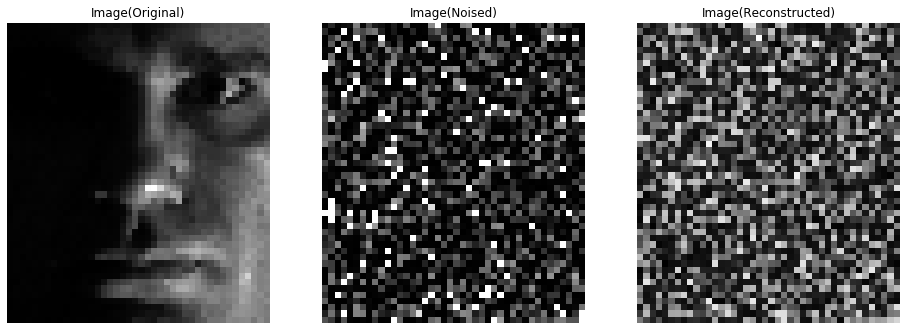

loss step-0: 145564.05030230168
criterion: 0.16922261496975483
loss step-10: 130207.8115651618
criterion: 0.023649583274106385
loss step-20: 121859.41870850832
criterion: 0.003181293372016201
loss step-30: 118493.98272442775
criterion: 0.0022973310694211725
loss step-40: 116598.6974997263
criterion: 0.0012458699823317862
loss step-50: 115352.13833851049
criterion: 0.0009603174104153505
loss step-60: 114390.17844857328
criterion: 0.0007433448214837295
loss step-70: 113645.38723426747
criterion: 0.0005880778011357058
loss step-80: 113051.6652016323
criterion: 0.0004752297588868449
loss step-90: 112573.41801778245
criterion: 0.00038452747094949345
loss step-100: 112188.01935131448
criterion: 0.0003113302882124124
loss step-110: 111876.05673751766
criterion: 0.0002535938507797879
loss step-120: 111621.4608212623
criterion: 0.0002083542328645178
loss step-130: 111411.6373909085
criterion: 0.00017288239990224998
loss step-140: 111236.91102703924
criterion: 0.00014484892759459238
loss step-15

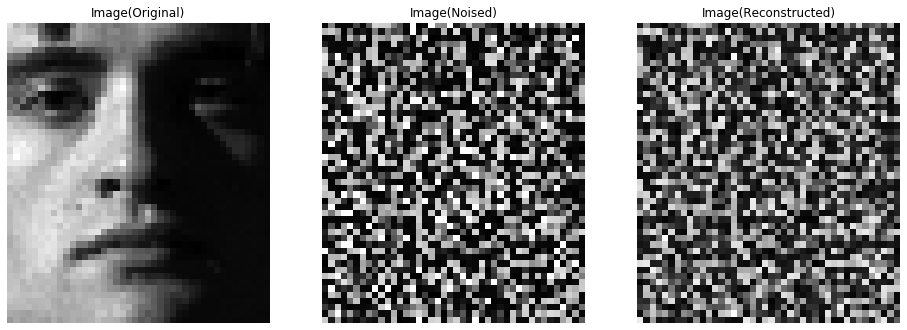

loss step-0: 145566.06780280545
criterion: 0.16888596392584057
loss step-10: 130687.6450314015
criterion: 0.0249098735566792
loss step-20: 122046.6729147181
criterion: 0.0028056768559155476
loss step-30: 118792.11214381833
criterion: 0.0025961027673408765
loss step-40: 116749.09317717153
criterion: 0.0012000960919820239
loss step-50: 115549.28799403693
criterion: 0.0009618492816357003
loss step-60: 114531.92612490634
criterion: 0.0008089230425640032
loss step-70: 113719.88113796253
criterion: 0.0006357133921414454
loss step-80: 113087.30223798282
criterion: 0.0004994430595911851
loss step-90: 112590.14378175481
criterion: 0.0003967034984306455
loss step-100: 112193.92683091134
criterion: 0.0003194702621823727
loss step-110: 111874.05659730446
criterion: 0.0002597734063752592
loss step-120: 111613.88901999839
criterion: 0.00021238347509870017
loss step-130: 111400.80142289204
criterion: 0.00017496252558377086
loss step-140: 111224.86106091455
criterion: 0.00014522957395407562
loss step-

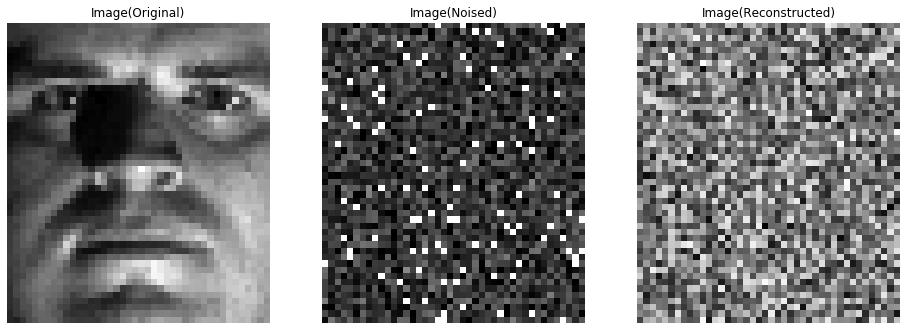

loss step-0: 145555.3662586946
criterion: 0.16888326192094064
loss step-10: 130968.60683669729
criterion: 0.02617055996142767
loss step-20: 121606.84245185541
criterion: 0.003020977083151207
loss step-30: 118395.13594579043
criterion: 0.0021932397646616925
loss step-40: 116636.02679203343
criterion: 0.0011337123034455083
loss step-50: 115483.50383107021
criterion: 0.0009102572562821559
loss step-60: 114543.29603897665
criterion: 0.000741199226780189
loss step-70: 113789.74002806343
criterion: 0.0005994229802845049
loss step-80: 113179.04634992224
criterion: 0.0004915571453334935
loss step-90: 112679.88338839142
criterion: 0.0004036468191011795
loss step-100: 112272.71370592488
criterion: 0.00032980212286810455
loss step-110: 111941.57634191074
criterion: 0.00026903530500544987
loss step-120: 111671.7581054998
criterion: 0.00022029703153436073
loss step-130: 111450.41727443525
criterion: 0.00018183045239811914
loss step-140: 111267.15967263815
criterion: 0.000151470707678064
loss step-1

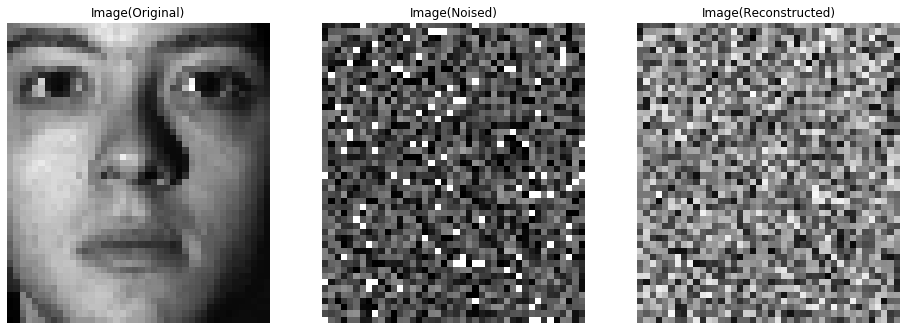

average RRE:0.24190917965768008,average acc:0.2076222038111019,average nmi:0.2760639207979771


In [497]:
data_sampling(X,0.1,5,4,0.9)

In [423]:
def data_sampling_cim(data,p,n,split,reduce,dataname = "EYB"):
    RRE_avg=[]
    ACC_avg=[]
    NMI_avg=[]
    for i in range(n):
        data_splited=data_split(data,split=split)
        noise_data = add_salt_noise(data_splited, p, data = dataname, reduce=4)
        cimnmf = CIM_NMF(n_components=40, tol=1e-7, max_iter=10000, skip_iter=1000)
        D, R = cimnmf.fit(X_noised)
        rre,acc,nmi=compute_metrics(data_splited, D.dot(R), R, y)
        reconstruct(data, noise_data, D.dot(R), data=dataname)
        RRE_avg.append(rre)
        ACC_avg.append(acc)
        NMI_avg.append(nmi)
    rre_avg=np.mean(RRE_avg)
    acc_avg=np.mean(ACC_avg)
    nmi_avg=np.mean(NMI_avg)
    print("average RRE:{},average acc:{},average nmi:{}".format(rre_avg,acc_avg,nmi_avg))

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7873879579802212, ACC: 0.21375310687655344, NMI:0.26521192872709465


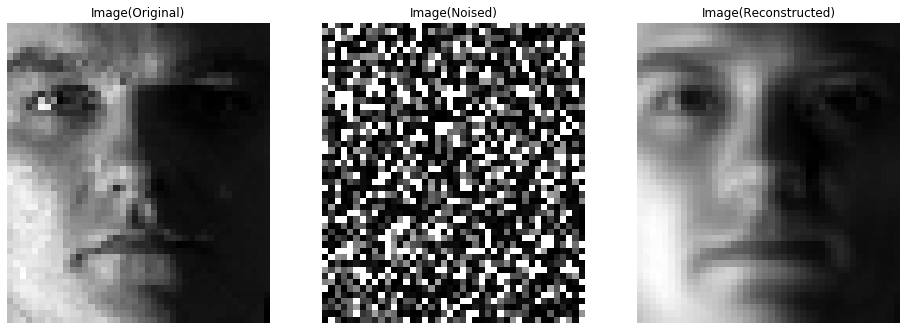

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7925342541182109, ACC: 0.23777961888980945, NMI:0.26888632817190183


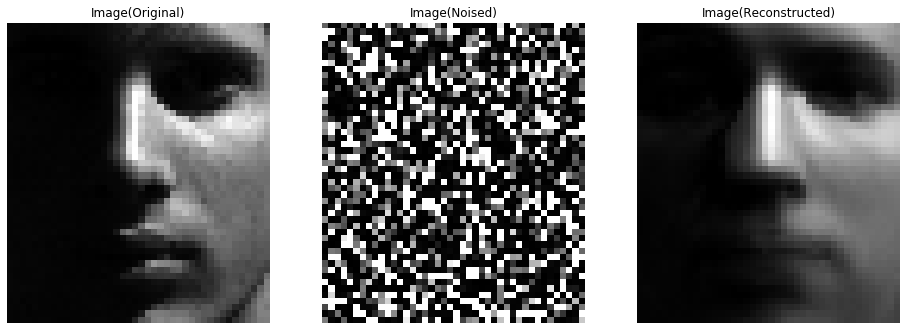

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7878015095366528, ACC: 0.2187241093620547, NMI:0.29697434283982166


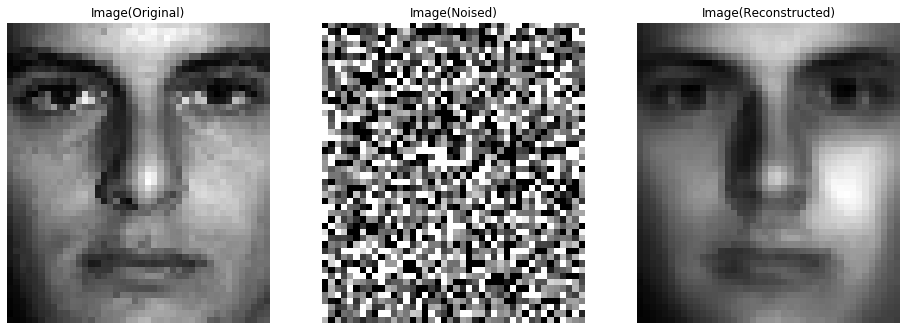

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7908797309612072, ACC: 0.23529411764705882, NMI:0.27962178228289947


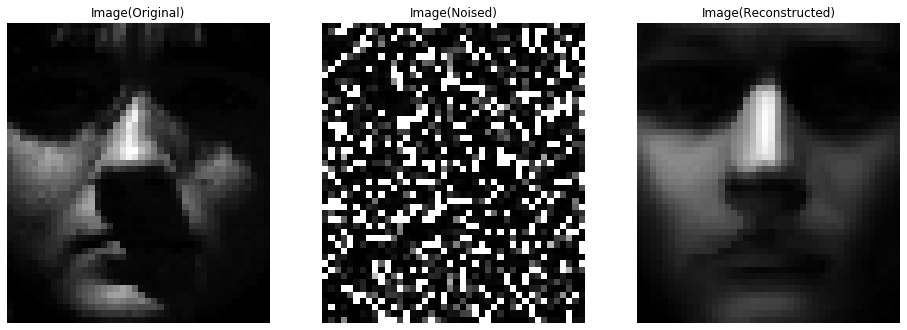

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7880808012019465, ACC: 0.21623860811930407, NMI:0.2685628747060179


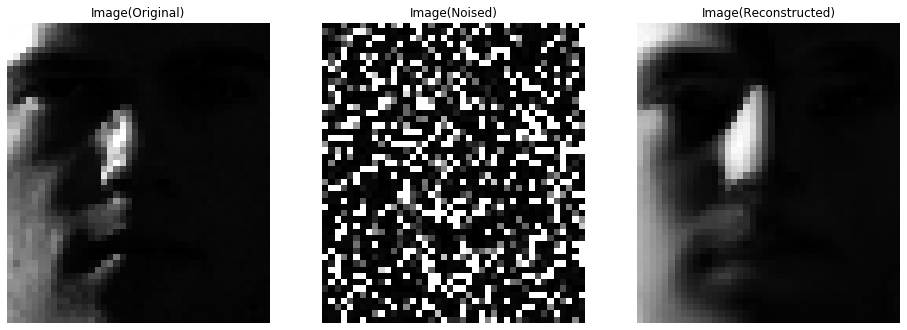

average RRE:0.7893368507596478,average acc:0.22435791217895612,average nmi:0.2758514513455471


In [425]:
data_sampling_cim(X,0.4,5,4,0.9)

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7893641190280527, ACC: 0.2315658657829329, NMI:0.2878019014181344


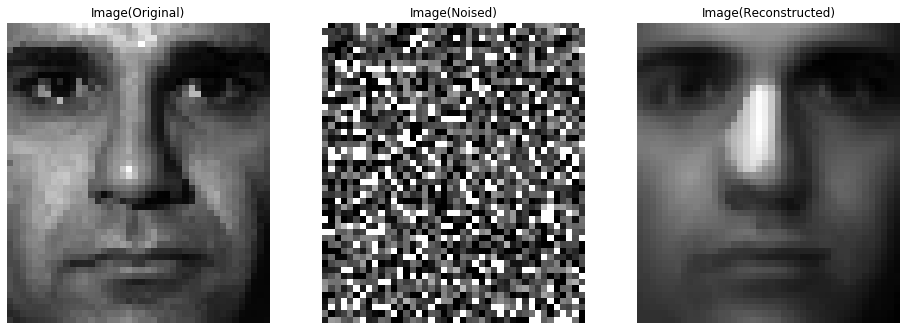

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7916194342678948, ACC: 0.231980115990058, NMI:0.2835973962597861


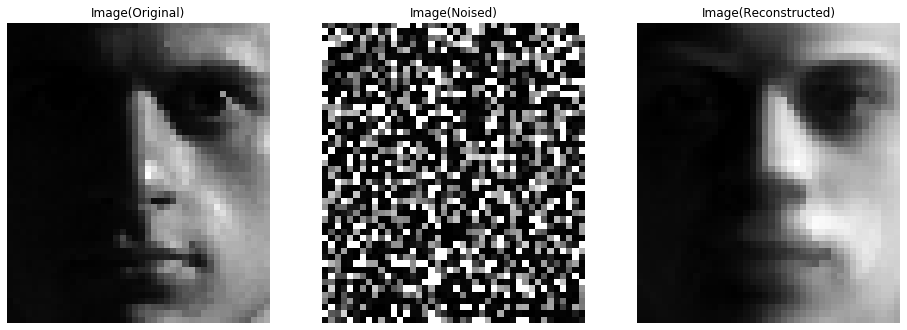

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.787974362935065, ACC: 0.21665285832642917, NMI:0.2545227189064597


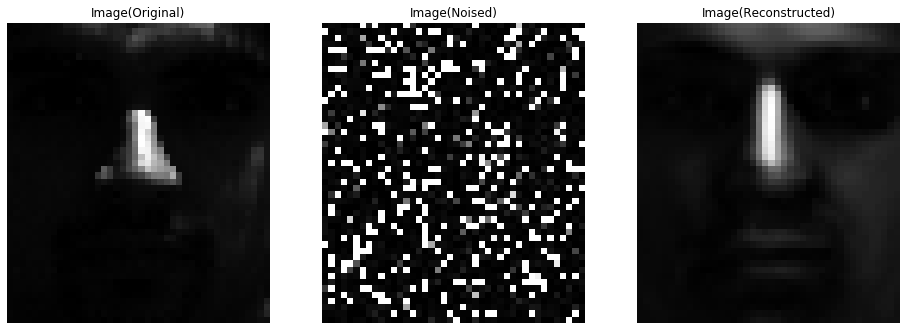

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7926708254565797, ACC: 0.22493786246893124, NMI:0.28052390697091173


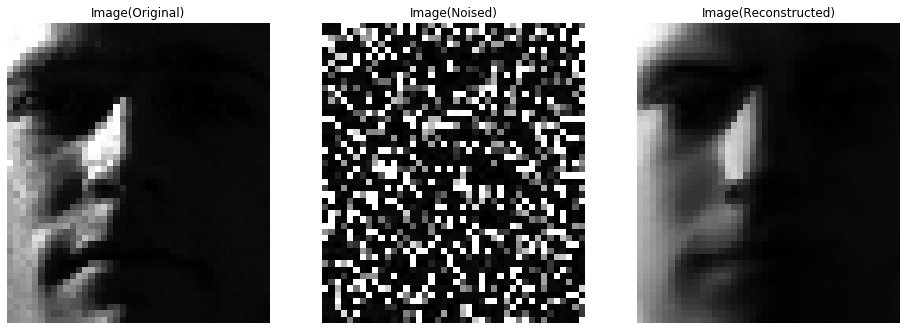

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7907373380370915, ACC: 0.2112676056338028, NMI:0.26232833042068165


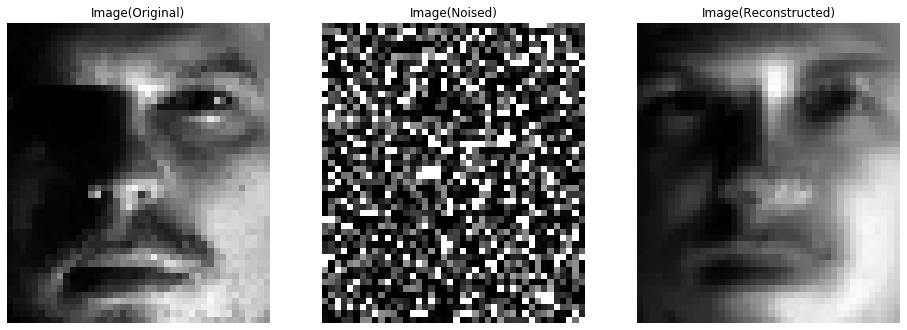

average RRE:0.7904732159449367,average acc:0.22328086164043084,average nmi:0.2737548507951947


In [426]:
data_sampling_cim(X,0.3,5,4,0.9)

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.792409789981827, ACC: 0.22908036454018227, NMI:0.27739132006049194


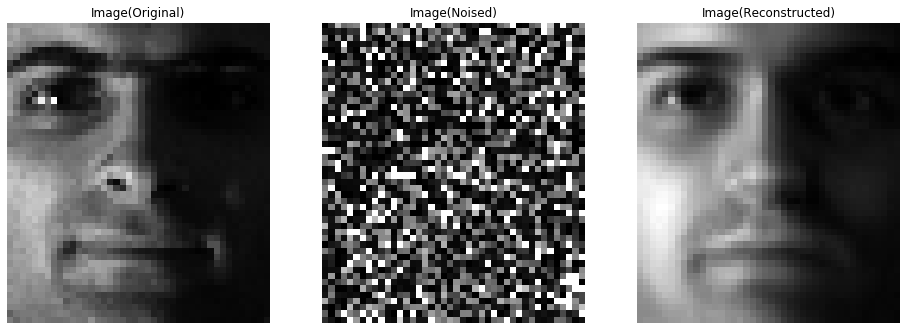

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7964429886008345, ACC: 0.21665285832642917, NMI:0.26653512251689526


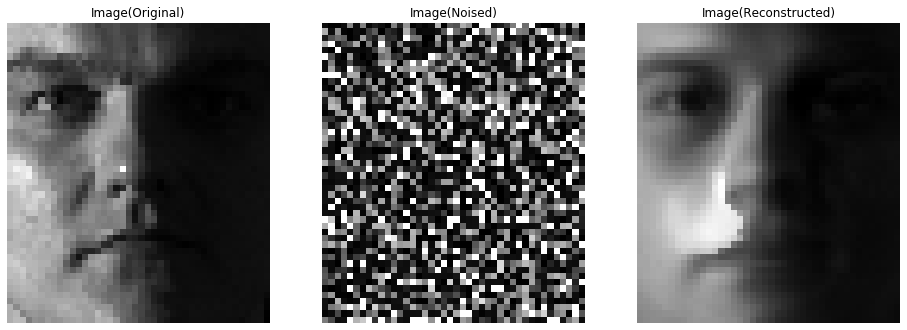

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7890691869250136, ACC: 0.2083678541839271, NMI:0.27036320680957143


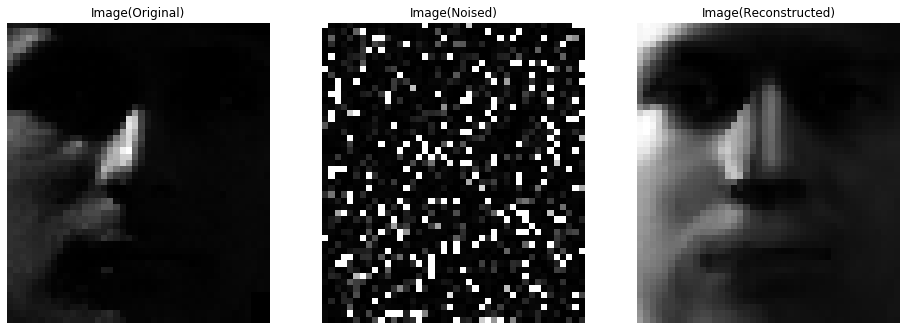

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7883594438501403, ACC: 0.21499585749792874, NMI:0.25998233643987595


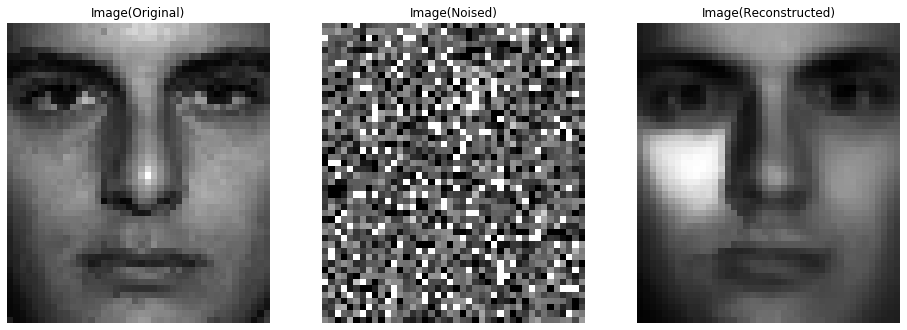

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7839036626916188, ACC: 0.24026512013256007, NMI:0.2681108367942674


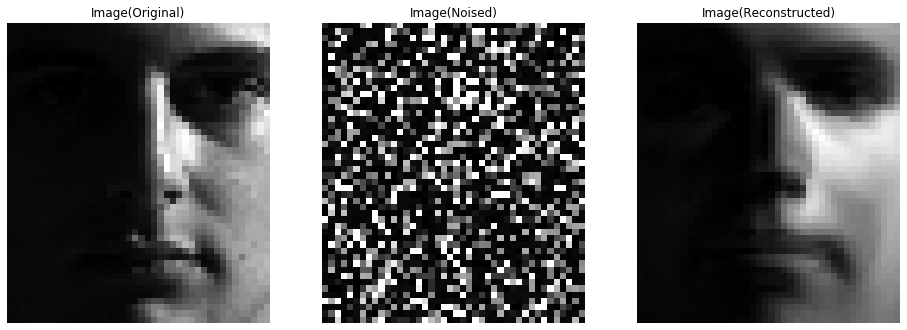

average RRE:0.7900370144098869,average acc:0.22187241093620544,average nmi:0.2684765645242204


In [428]:
data_sampling_cim(X,0.2,5,4,0.9)

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7861492249247624, ACC: 0.2212096106048053, NMI:0.26999574336653565


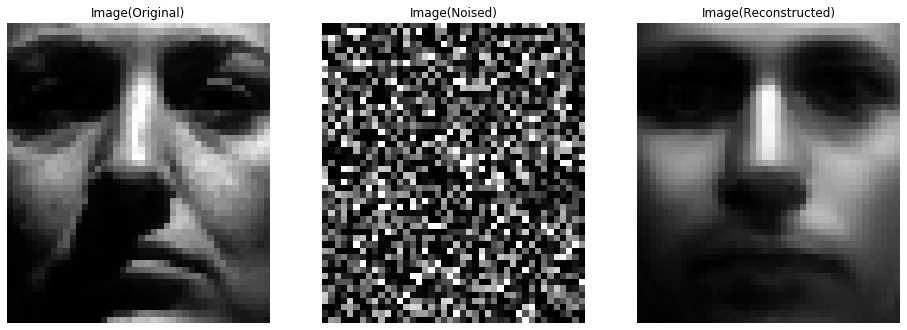

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7844115938314579, ACC: 0.22203811101905552, NMI:0.27240964792738614


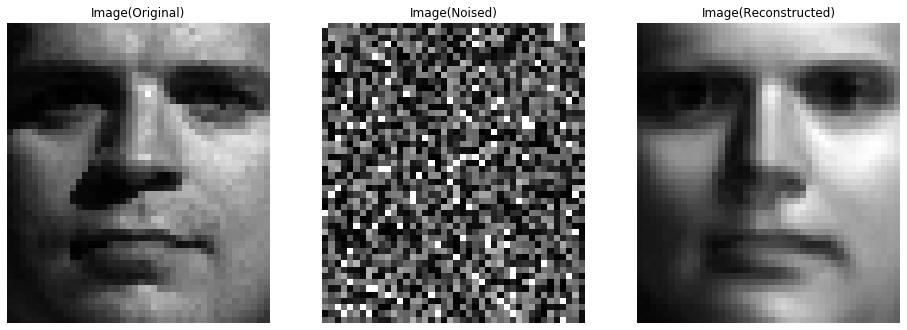

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7905279494096058, ACC: 0.23363711681855842, NMI:0.2754514559006339


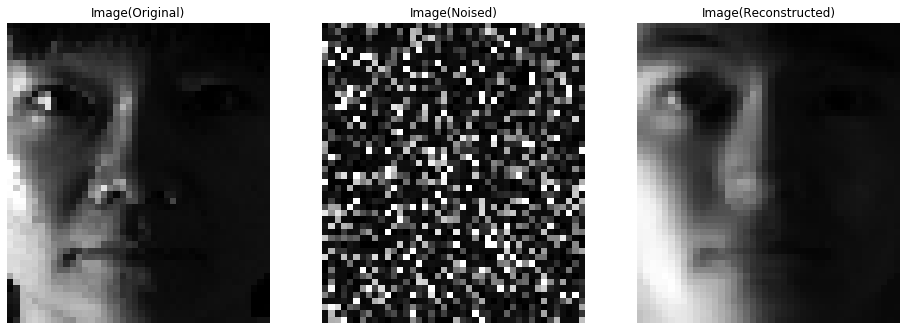

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7869889144029317, ACC: 0.2203811101905551, NMI:0.2729977719970014


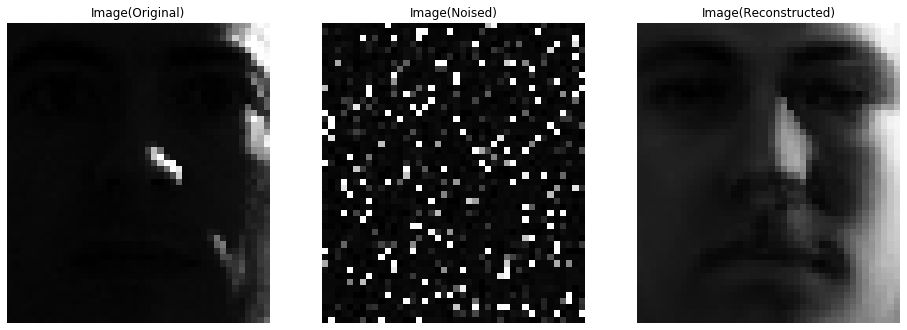

iter-   0, criterion-0.00087764, 4842457.248024729
iter-1000, criterion-0.00338470, 4826066.922946272
iter-2000, criterion-6.0472e-05, 4825775.082358602
RRE: 0.7919663676752109, ACC: 0.2444076222038111, NMI:0.2947005844107902


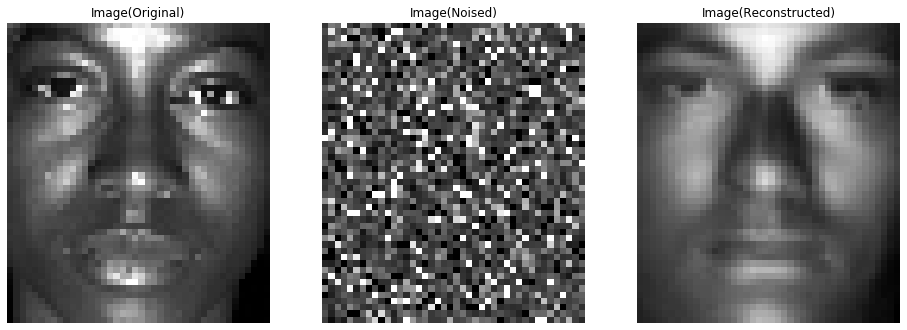

average RRE:0.7880088100487936,average acc:0.22833471416735712,average nmi:0.27711104072046944


In [429]:
data_sampling_cim(X,0.1,5,4,0.9)

In [507]:
def data_sampling_ORL(data,p,n,split,reduce=3,dataname = "ORL"):
    RRE_avg=[]
    ACC_avg=[]
    NMI_avg=[]
    for i in range(n):
        data_splited=data_split(data,split=split)
        noise_data = add_salt_noise(data_splited, p, data = dataname, reduce=3)
        D, R, losses = base_nmf(noise_data, n_components = 40, init=random_init, steps=MAX_STEPS)
        rre,acc,nmi=compute_metrics(data_splited, D.dot(R), R, y2)
        reconstruct(data, noise_data, D.dot(R), data=dataname)
        RRE_avg.append(rre)
        ACC_avg.append(acc)
        NMI_avg.append(nmi)
    rre_avg=np.mean(RRE_avg)
    acc_avg=np.mean(ACC_avg)
    nmi_avg=np.mean(NMI_avg)
    print("average RRE:{},average acc:{},average nmi:{}".format(rre_avg,acc_avg,nmi_avg))

loss step-0: 63949.93900457093
criterion: 0.10507730444307312
loss step-10: 62933.15323147187
criterion: 0.0014197554427309717
loss step-20: 62046.4627139798
criterion: 0.001415464618932822
loss step-30: 61229.311508652245
criterion: 0.001215342547576527
loss step-40: 60589.365642735946
criterion: 0.0009184709016409749
loss step-50: 60117.618500789584
criterion: 0.0006801725205897972
loss step-60: 59769.196010501066
criterion: 0.0005088288188905978
loss step-70: 59507.52414348185
criterion: 0.00038749707902514455
loss step-80: 59306.78584130106
criterion: 0.000301816737769731
loss step-90: 59148.60816380446
criterion: 0.00024160097953848946
loss step-100: 59020.77036624261
criterion: 0.00019759780699504304
loss step-110: 58915.464627668836
criterion: 0.00016434017918475383
loss step-120: 58827.302712175835
criterion: 0.00013876470982831756
loss step-130: 58752.456801473934
criterion: 0.0001185916986373802
loss step-140: 58688.271739113814
criterion: 0.0001021754373955776
loss step-150:

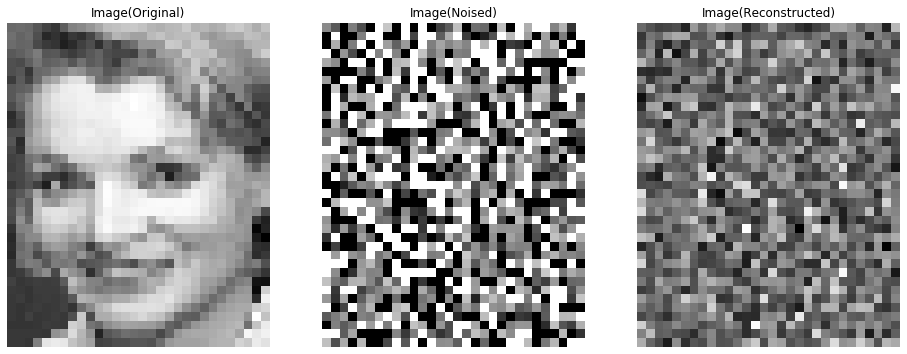

loss step-0: 63917.86372293879
criterion: 0.10515577329064855
loss step-10: 62896.55731192967
criterion: 0.0014220430635613973
loss step-20: 62011.287450945405
criterion: 0.0014127462793498908
loss step-30: 61194.89454060005
criterion: 0.0012171981370692965
loss step-40: 60553.05016427444
criterion: 0.0009228028644520561
loss step-50: 60079.79559796909
criterion: 0.0006814249014219971
loss step-60: 59732.351296036824
criterion: 0.0005058082019812827
loss step-70: 59472.996618050005
criterion: 0.00038411875771618875
loss step-80: 59273.67188907307
criterion: 0.000300484761598674
loss step-90: 59116.154703464425
criterion: 0.00024071937029708452
loss step-100: 58988.96281614614
criterion: 0.00019656221790893447
loss step-110: 58884.260470743146
criterion: 0.00016357898124555678
loss step-120: 58796.41743843909
criterion: 0.00013854263513926103
loss step-130: 58721.61252813555
criterion: 0.00011873611706345727
loss step-140: 58657.28265311005
criterion: 0.00010262100683355215
loss step-15

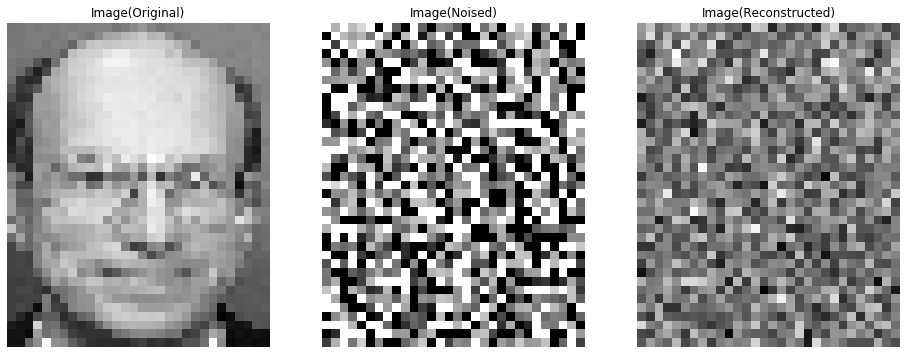

loss step-0: 63940.05312880946
criterion: 0.10517878632507394
loss step-10: 62925.36795779269
criterion: 0.001412304938571121
loss step-20: 62044.32479553461
criterion: 0.001407091748656294
loss step-30: 61227.77148522989
criterion: 0.001221861787617562
loss step-40: 60581.66084061257
criterion: 0.0009281032260228592
loss step-50: 60106.731432635526
criterion: 0.0006826315656837102
loss step-60: 59757.67199976175
criterion: 0.0005095890312144537
loss step-70: 59495.35605659545
criterion: 0.0003891560798034918
loss step-80: 59293.70484876145
criterion: 0.00030287709586358227
loss step-90: 59135.73229892471
criterion: 0.00024021538116778514
loss step-100: 59009.302009858366
criterion: 0.00019468227838631325
loss step-110: 58905.911192982974
criterion: 0.00016099600186880728
loss step-120: 58819.72584024383
criterion: 0.00013547067740716124
loss step-130: 58746.76873645269
criterion: 0.00011549384365998858
loss step-140: 58684.26541449261
criterion: 9.958469102878498e-05
RRE: 0.3968718430

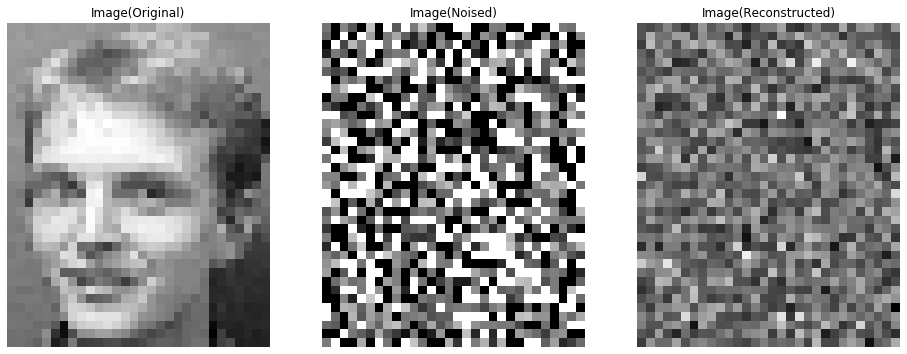

loss step-0: 63942.848936609174
criterion: 0.10512314417040157
loss step-10: 62930.53664475244
criterion: 0.0014056653648628506
loss step-20: 62054.58065681209
criterion: 0.0013985684688534593
loss step-30: 61243.82672822754
criterion: 0.0012106596108659587
loss step-40: 60603.22074324029
criterion: 0.0009224363741772238
loss step-50: 60128.54912296667
criterion: 0.0006844931238094743
loss step-60: 59778.4047156944
criterion: 0.0005103706242925606
loss step-70: 59516.16704624403
criterion: 0.0003882469508163749
loss step-80: 59314.95567181305
criterion: 0.0003022708799614508
loss step-90: 59157.09767631057
criterion: 0.0002401025793796944
loss step-100: 59030.676717108596
criterion: 0.0001945349441565208
loss step-110: 58927.44744824204
criterion: 0.0001604717219299169
loss step-120: 58841.69616830601
criterion: 0.00013445800462297418
loss step-130: 58769.44465668359
criterion: 0.00011407954559066435
loss step-140: 58707.85400644642
criterion: 9.783663599740111e-05
RRE: 0.3997824876627

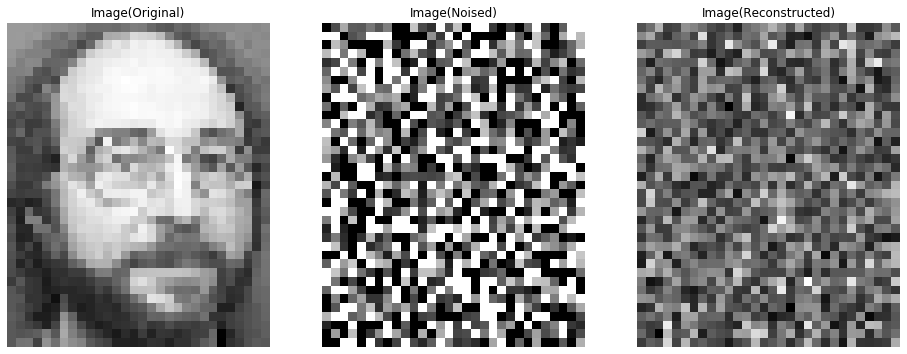

loss step-0: 63902.88875782946
criterion: 0.10527470178007439
loss step-10: 62891.77022341726
criterion: 0.0014116648467944887
loss step-20: 62011.391012388565
criterion: 0.0014057144031626174
loss step-30: 61199.942413714874
criterion: 0.0012095379701651191
loss step-40: 60558.97850714455
criterion: 0.0009275026327008194
loss step-50: 60079.15427536142
criterion: 0.0006960051838789396
loss step-60: 59721.90836531698
criterion: 0.0005226436364737026
loss step-70: 59453.8095549448
criterion: 0.0003964355998162199
loss step-80: 59249.235490085826
criterion: 0.00030697132788941415
loss step-90: 59089.33956214385
criterion: 0.00024308984351025347
loss step-100: 58961.97210619892
criterion: 0.00019542411273195398
loss step-110: 58858.88844221365
criterion: 0.00015983157768490264
loss step-120: 58773.80105034884
criterion: 0.00013338257343771594
loss step-130: 58702.21539243238
criterion: 0.00011319177304258288
loss step-140: 58641.144954550145
criterion: 9.715300087541614e-05
RRE: 0.3978392

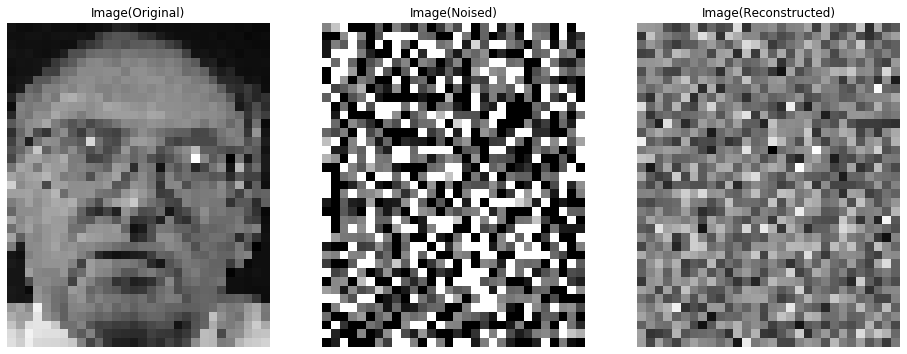

average RRE:0.3981192095437166,average acc:0.1955,average nmi:0.35785364576440126


In [514]:
data_sampling_ORL(X2,0.5,5,3,0.9)

In [533]:
def data_sampling_cim_ORL(data,p,n,split,reduce,dataname = "ORL"):
    RRE_avg=[]
    ACC_avg=[]
    NMI_avg=[]
    for i in range(n):
        data_splited=data_split(data,split=split)
        noise_data = add_salt_noise(data_splited, p, data = dataname, reduce=3)
        cimnmf = CIM_NMF(n_components=40, tol=1e-7, max_iter=10000, skip_iter=1000)
        D, R = cimnmf.fit(X_noised)
        rre,acc,nmi=compute_metrics(data_splited, D.dot(R), R, y2)
        reconstruct(data, noise_data, D.dot(R), data=dataname)
        RRE_avg.append(rre)
        ACC_avg.append(acc)
        NMI_avg.append(nmi)
    rre_avg=np.mean(RRE_avg)
    acc_avg=np.mean(ACC_avg)
    nmi_avg=np.mean(NMI_avg)
    print("average RRE:{},average acc:{},average nmi:{}".format(rre_avg,acc_avg,nmi_avg))

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7864528966984897, ACC: 0.23446561723280862, NMI:0.28438162439616765


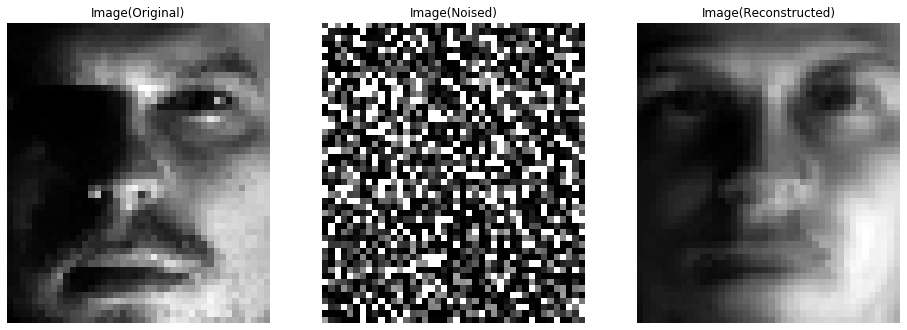

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7845256808558329, ACC: 0.22949461474730737, NMI:0.2906147744964214


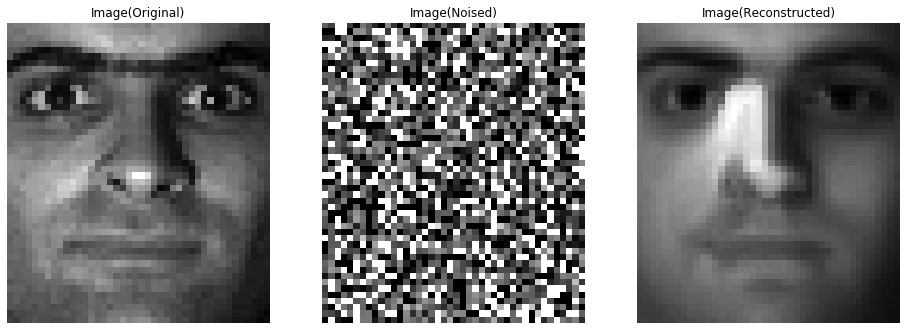

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7894266724866634, ACC: 0.23695111847555925, NMI:0.29046703798151063


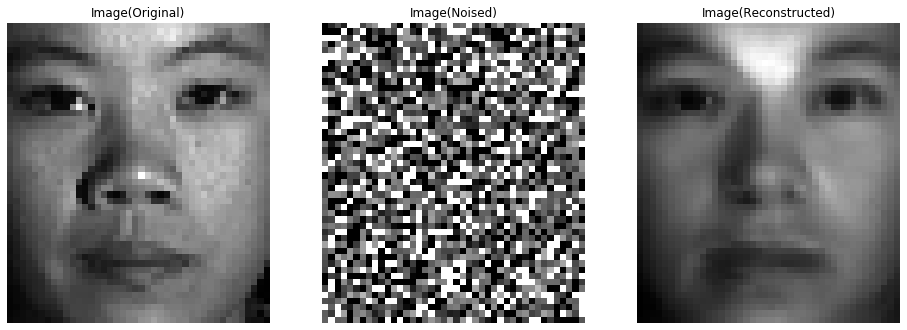

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7890605252031033, ACC: 0.23032311516155757, NMI:0.30411488104370527


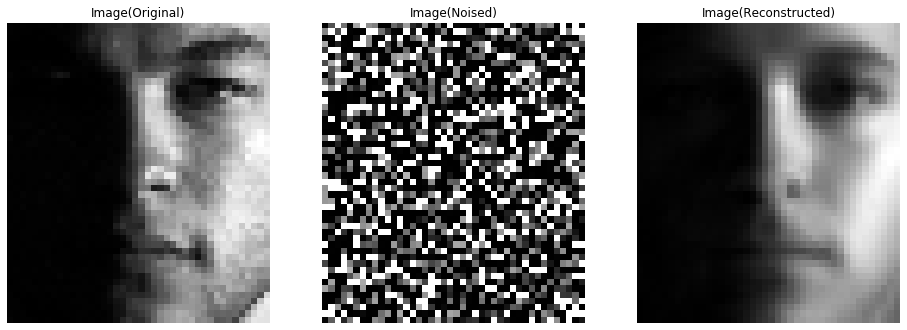

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7876285698903006, ACC: 0.2452361226180613, NMI:0.29632398243223457


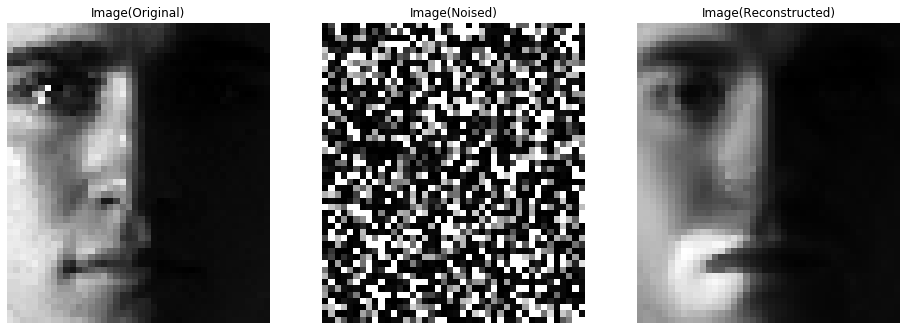

average RRE:0.787418869026878,average acc:0.23529411764705882,average nmi:0.2931804600700079


In [522]:
data_sampling_cim(X,0.4,5,3,0.9)

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7925568731873814, ACC: 0.2328086164043082, NMI:0.286733037090579


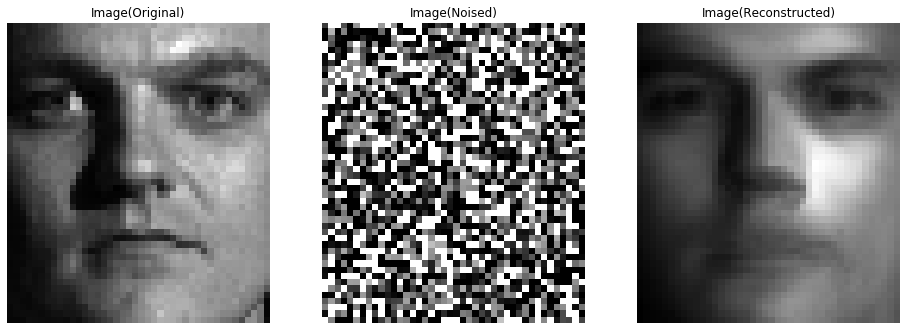

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7838303706277225, ACC: 0.22493786246893124, NMI:0.2797122974641251


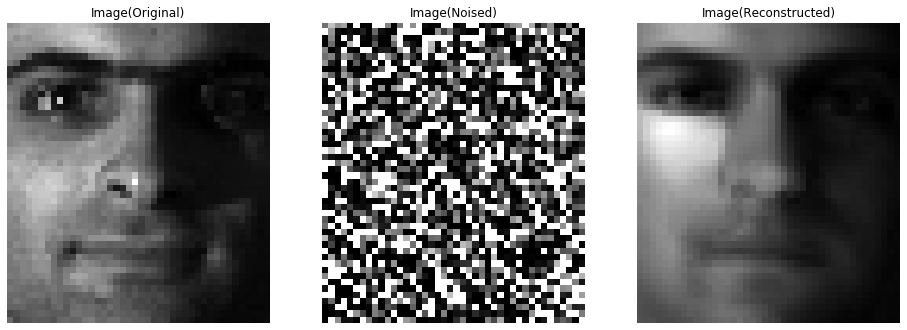

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7816681478728524, ACC: 0.23943661971830985, NMI:0.2853723748214578


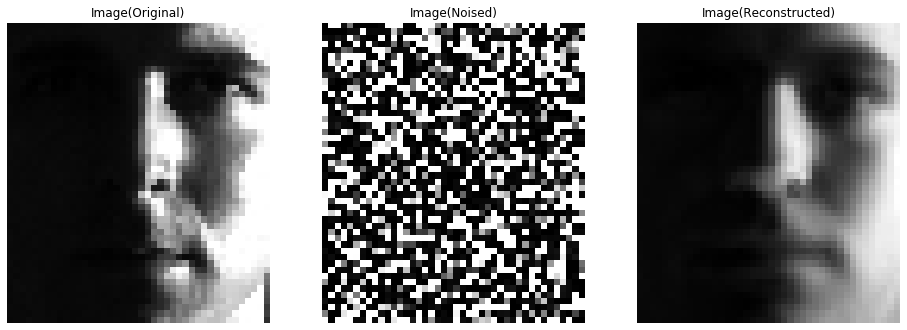

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7897503187240146, ACC: 0.22949461474730737, NMI:0.29128282726020693


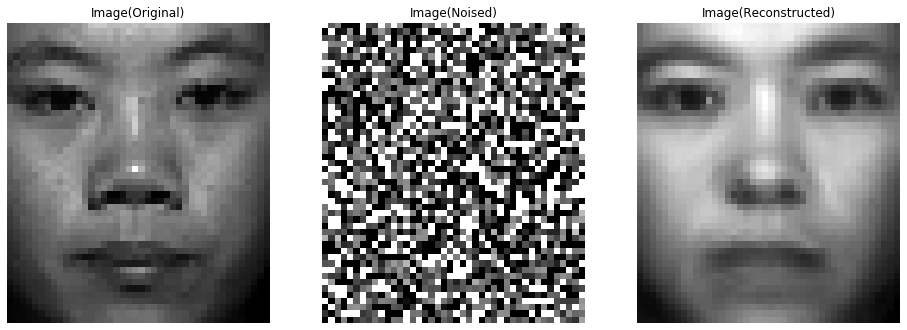

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7869677806216346, ACC: 0.24855012427506215, NMI:0.2837550106107412


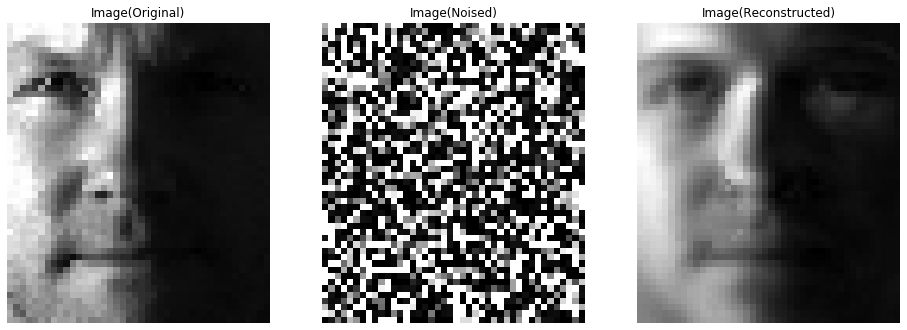

average RRE:0.7869546982067211,average acc:0.23504556752278374,average nmi:0.28537110944942196


In [523]:
data_sampling_cim(X,0.5,5,3,0.9)

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7827796774449193, ACC: 0.23032311516155757, NMI:0.3032601645761106


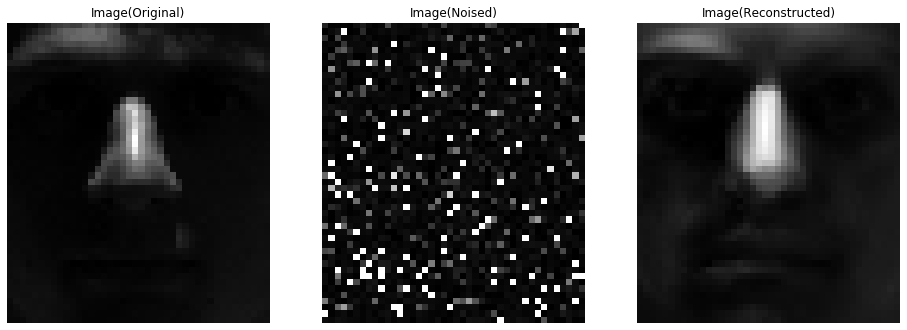

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7884068671198855, ACC: 0.21706710853355426, NMI:0.28070097008459466


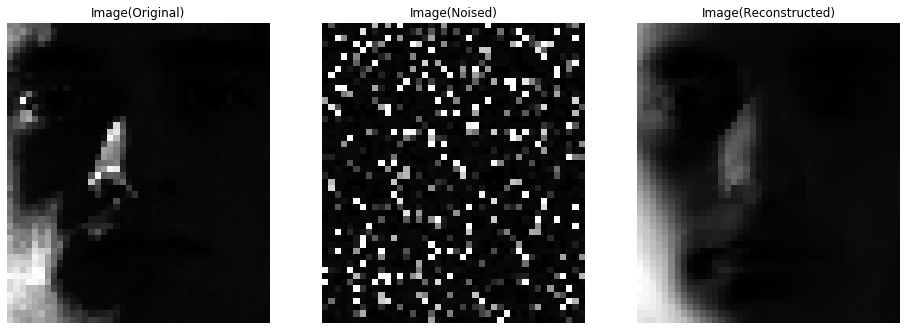

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7822162760159872, ACC: 0.2435791217895609, NMI:0.28605465635527544


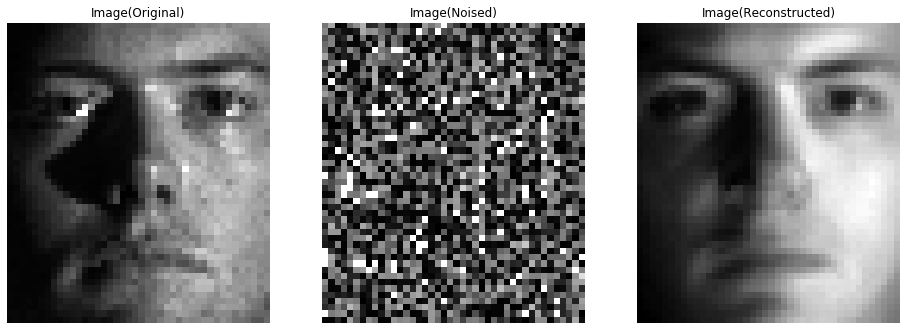

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.7825540366736773, ACC: 0.24813587406793702, NMI:0.29642597807751253


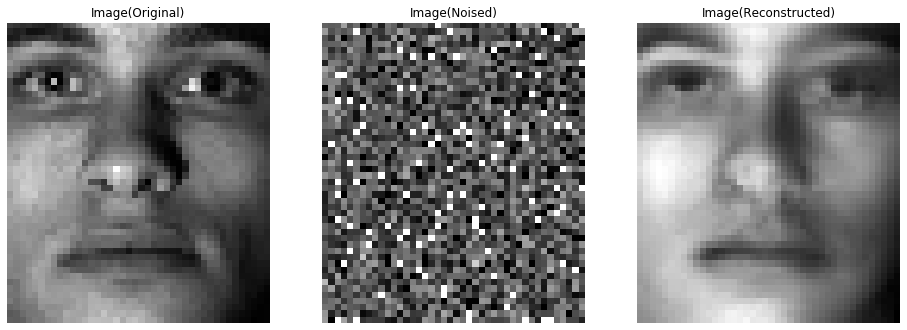

iter-   0, criterion-0.00087732, 4842429.513763404
iter-1000, criterion-0.00341000, 4825916.767780584
iter-2000, criterion-6.6593e-05, 4825595.396234591
RRE: 0.787274782657279, ACC: 0.23695111847555925, NMI:0.29141920964651613


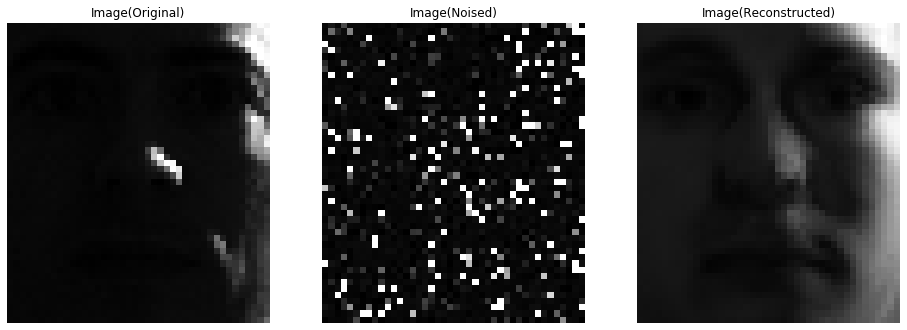

average RRE:0.7846463279823496,average acc:0.2352112676056338,average nmi:0.29157219574800186


In [534]:
data_sampling_cim(X,0.1,5,3,0.9)